<a href="https://colab.research.google.com/github/Mehreen66/MachineLearning/blob/main/CEEMDAN-S-C-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset
data = pd.read_csv('sp500.csv')

# Extract relevant columns
closing_price = data['Close'].values
other_features = data[['Open', 'High', 'Low', 'Volume']].values

# Normalize the features with separate scalers
closing_price_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_closing_price = closing_price_scaler.fit_transform(closing_price.reshape(-1, 1))

features_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_other_features = features_scaler.fit_transform(other_features)


In [12]:

!pip install EMD-signal
from PyEMD import CEEMDAN

# Initialize CEEMDAN
ceemdan = CEEMDAN()
imfs = ceemdan.ceemdan(scaled_closing_price.flatten())


In [13]:
from scipy.signal import savgol_filter

# Apply SG filter to each IMF
smoothed_imfs = np.array([savgol_filter(imf, window_length=5, polyorder=2) for imf in imfs])


In [14]:
# Combine all features
combined_features = np.hstack([smoothed_imfs.T, scaled_other_features])


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense

# Reshape data for Conv1D
combined_features = combined_features.reshape((combined_features.shape[0], combined_features.shape[1], 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(combined_features.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


In [16]:
# Prepare target variable
target = scaled_closing_price

# Split data into training and testing sets
split = int(len(combined_features) * 0.8)
X_train, X_test = combined_features[:split], combined_features[split:]
y_train, y_test = target[:split], target[split:]

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/50
59/59 [==============================] - 4s 24ms/step - loss: 0.0077 - val_loss: 7.8472e-04
Epoch 2/50
59/59 [==============================] - 1s 14ms/step - loss: 1.9160e-04 - val_loss: 9.7149e-05
Epoch 3/50
59/59 [==============================] - 1s 14ms/step - loss: 3.3617e-05 - val_loss: 8.5275e-05
Epoch 4/50
59/59 [==============================] - 1s 20ms/step - loss: 2.1908e-05 - val_loss: 7.1438e-05
Epoch 5/50
59/59 [==============================] - 1s 23ms/step - loss: 1.9970e-05 - val_loss: 6.9830e-05
Epoch 6/50
59/59 [==============================] - 1s 24ms/step - loss: 2.1892e-05 - val_loss: 6.9089e-05
Epoch 7/50
59/59 [==============================] - 1s 15ms/step - loss: 1.8167e-05 - val_loss: 7.1526e-05
Epoch 8/50
59/59 [==============================] - 1s 14ms/step - loss: 1.8275e-05 - val_loss: 7.7690e-05
Epoch 9/50
59/59 [==============================] - 1s 14ms/step - loss: 1.9051e-05 - val_loss: 6.4357e-05
Epoch 10/50
59/59 [======================

30/30 [==============================] - 0s 13ms/step - loss: 1.1633e-04
Test Loss: 0.00011632850510068238
30/30 [==============================] - 2s 10ms/step


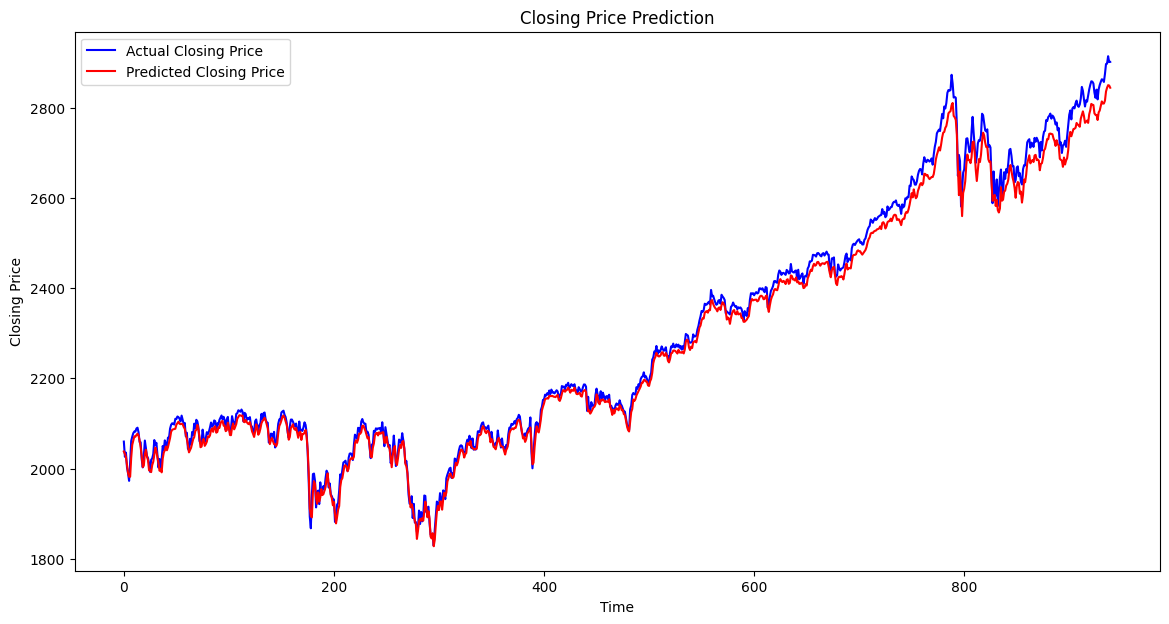

In [17]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and actual values using the closing price scaler
predicted_closing_price = closing_price_scaler.inverse_transform(predictions)
actual_closing_price = closing_price_scaler.inverse_transform(y_test)

# Optional: Flatten the arrays if they have an extra dimension
predicted_closing_price = predicted_closing_price.flatten()
actual_closing_price = actual_closing_price.flatten()

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(actual_closing_price, color='blue', label='Actual Closing Price')
plt.plot(predicted_closing_price, color='red', label='Predicted Closing Price')
plt.title('Closing Price Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()
